Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


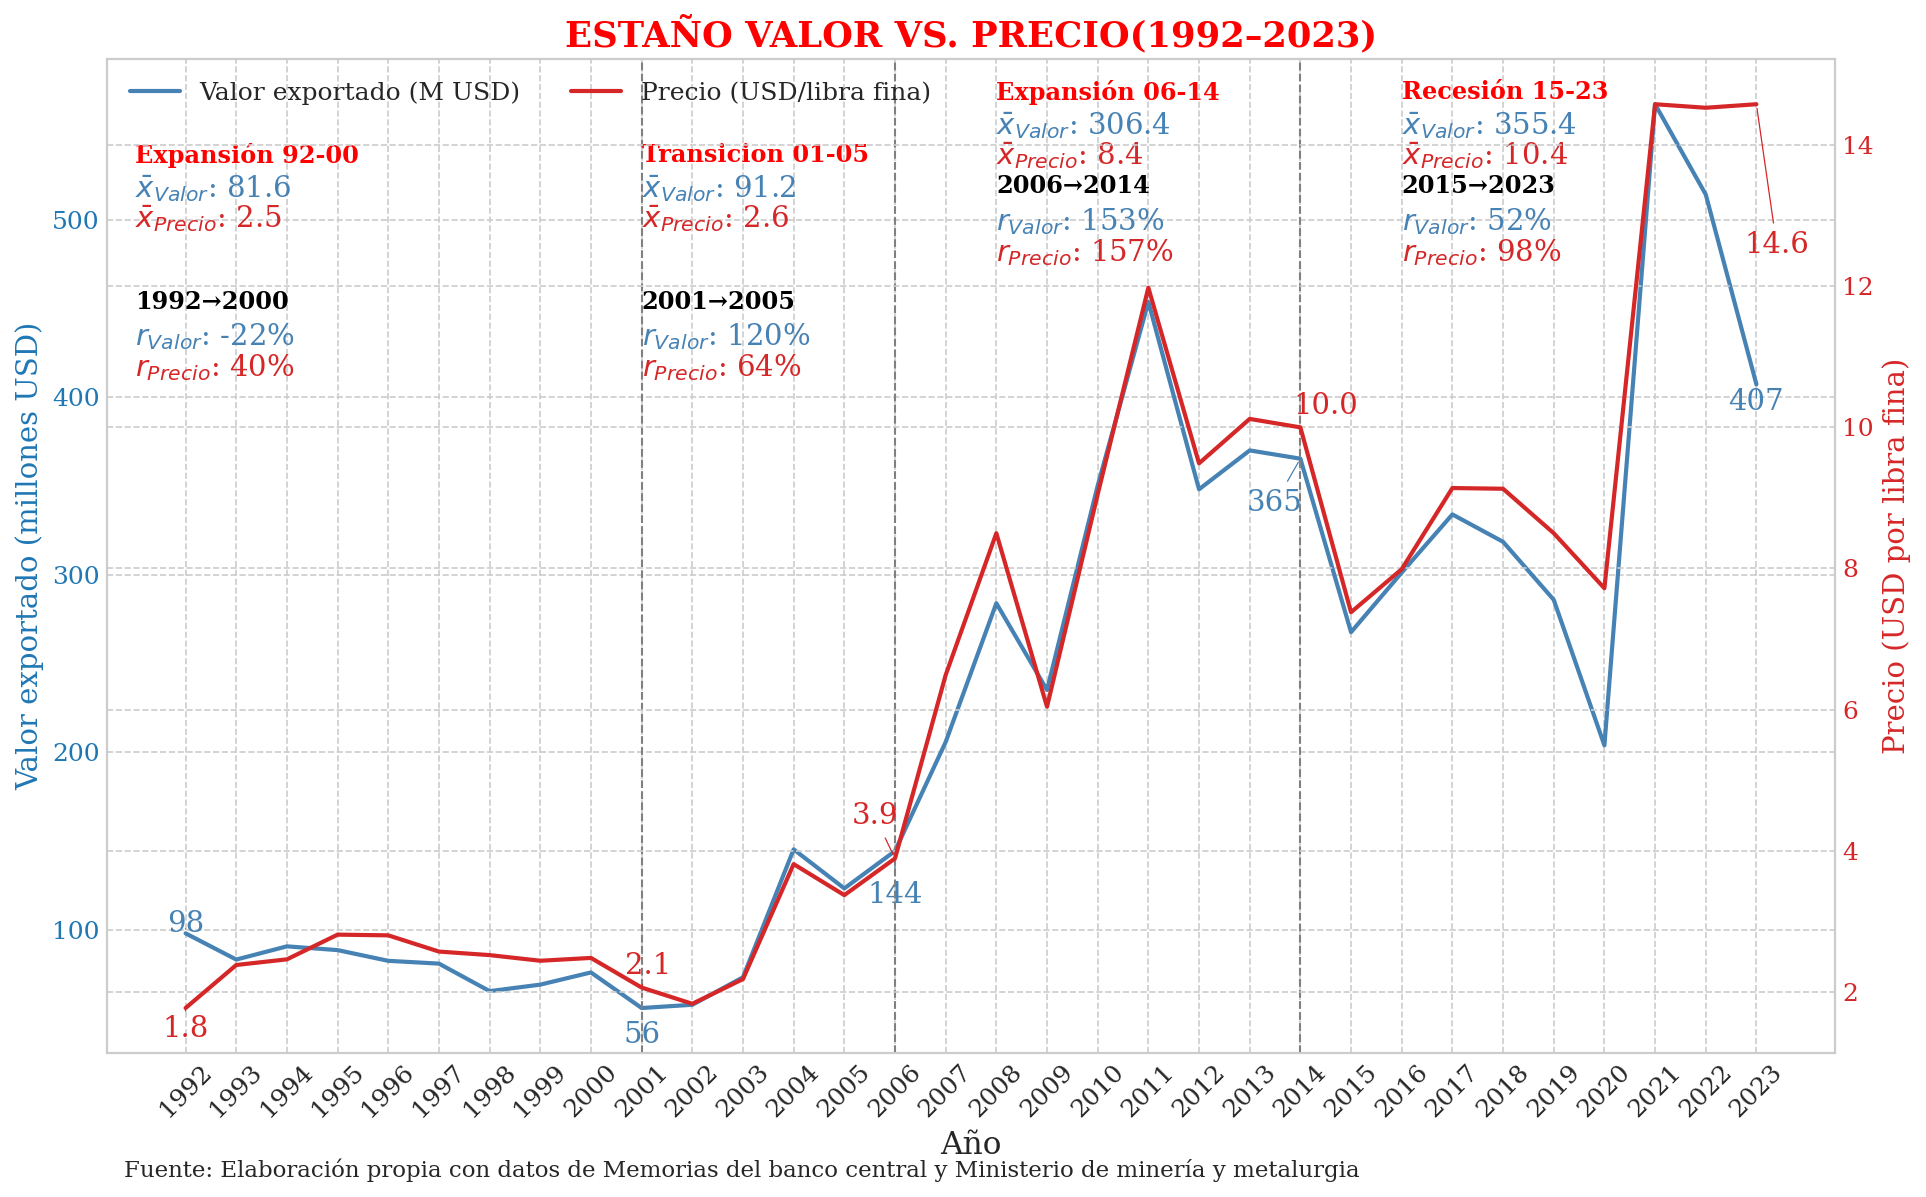

{1952: 'Crisis', 1956: 'Expansión', 1970: 'Recesión', 1982: 'Crisis', 1985: 'Expansión', 2001: 'Transición', 2006: 'Expansión', 2014: 'Recesión'}


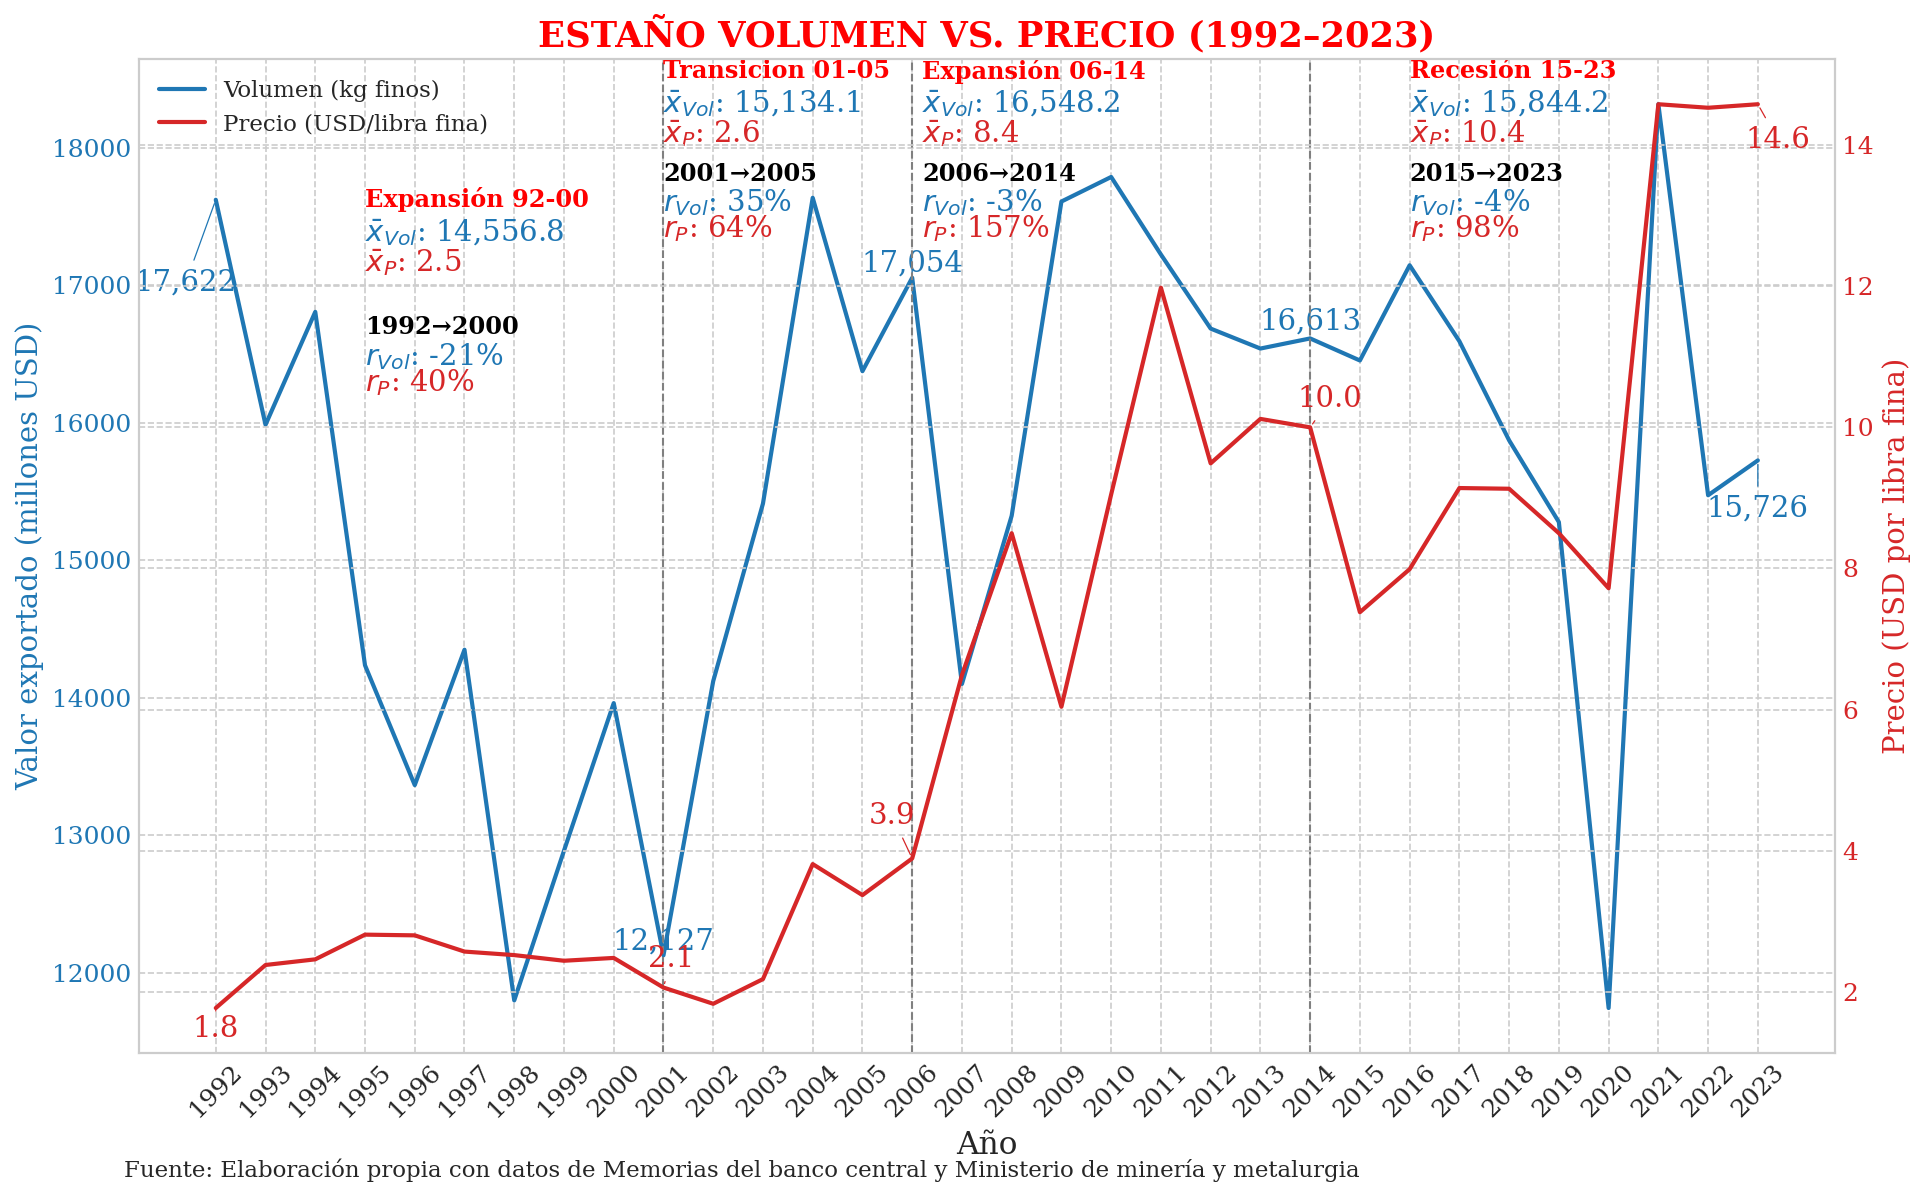

In [6]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *

# 0. Ciclos y carpetas
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)
set_style()

# 1. Datos ────────────────────────────────────────────────────────────────
df_estanio = get_df(
    sql="SELECT año, estaño_volumen, estaño_valor "
        "FROM exportaciones_minerales_totales WHERE año > 1991",
    conn_str="../../../../db/proyectomacro.db",
)
df_precio = get_df(
    sql="SELECT año, estaño AS precio_usd_lf "
        "FROM precio_oficial_minerales WHERE año > 1991",
    conn_str="../../../../db/proyectomacro.db",
)

df = df_estanio.join(df_precio, how="inner")
df["estanio_valor_musd"] = df["estaño_valor"] / 1_000        # miles → millones
df.drop(columns="estaño_valor", inplace=True)

# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols   = ["estanio_valor_musd", "precio_usd_lf"]
abbr   = {"estanio_valor_musd": "Valor", "precio_usd_lf": "Precio"}
colors = {"estanio_valor_musd": "#4682b4", "precio_usd_lf": "#d62728"}  # azul acero + rojo

CYCLES=adjust_cycles(df,CYCLES)
cycle_stats = {n: df.loc[s, cols].mean().to_dict() for n, s in CYCLES.items()}
periodos=adjust_periods(df, periodos_tasas)
annot_years = adjust_annot_years(df, annot_years)  # de config.py
hitos_offset = {yr: .60 for yr in hitos_v}

annotation_offsets = {
    "estanio_valor_musd": {
        1992: (0,   5),    # antes 1992 → 1985
        2001: (0,  -15),   # antes 2000 → 2001
        2006: (0,  -25), 
        2014: (-0.5, -25),
        2023: (0,  -10),   # antes 2023 stays
    },
    "precio_usd_lf": {
        1992: (0,   -0.3),
        2001: (0.13, 0.3),
        2006: (-0.4, 0.6),
        2014: (0.5,  0.3),
        2023: (0.4, -2),
    },
}

period_growth_offsets = {
    "1992-2000": (1991, 0.78),  # antes "1992-2000"
    "2001-2005": (2001, 0.78),  # antes "2000-2006"
    "2006-2014": (2008, 0.89),
    "2015-2023": (2016, 0.89),  # antes "2014-2023"
}

cycle_text_offsets = {
    "Expansión 92-00":  (1991, 0.92),  # antes "Expansión 92-99"
    "Transicion 01-05": (2001, 0.92),  # antes "Crisis 00-05"
    "Expansión 06-14":  (2008, 0.98),
    "Recesión 15-23":   (2016, 0.98),  # antes "Recesión 14-23"
}

# ───────────────────────  GRÁFICA DUAL AXIS (valor–precio) ───────────────────────
# 1) Definimos las listas para cada eje
left_series  = [("estanio_valor_musd", "Valor exportado (M USD)")]
right_series = [("precio_usd_lf",      "Precio (USD/libra fina)")]

fig, ax_val, ax_price = init_dual_axis_plot(
    df=df,
    left_series=left_series,
    right_series=right_series,
    colors=colors,
    title=f"ESTAÑO VALOR VS. PRECIO({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Valor exportado (millones USD)",
    right_ylabel="Precio (USD por libra fina)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia"
)
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})
add_cycle_means_multi(
    ax_val, cycle_stats, cycle_text_offsets,
    abbr, colors,
    line_spacing=df["estanio_valor_musd"].max()*0.03,
    value_fmt="{:,.1f}"
)
add_year_value_annotations(
    ax_val, df, annot_years, ["estanio_valor_musd"],
    {"estanio_valor_musd": annotation_offsets["estanio_valor_musd"]},
    {"estanio_valor_musd": colors["estanio_valor_musd"]},
    arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, annot_years, ["precio_usd_lf"],
    {"precio_usd_lf": annotation_offsets["precio_usd_lf"]},
    {"precio_usd_lf": colors["precio_usd_lf"]},
    arrow_lw=0.6,
    value_fmt="{:,.1f}"
)
add_period_growth_annotations_multi(
    ax_val, df, periodos, cols,
    period_growth_offsets, colors, abbr
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "estanio_valor_precio_dual_axis.png"), dpi=300)
plt.show()

# ──────────────────  GRÁFICA DUAL AXIS (volumen-precio) ──────────────────
cols_vol   = ["estaño_volumen", "precio_usd_lf"]
colors_vol = {
    "estaño_volumen": "tab:blue",
    "precio_usd_lf":  colors["precio_usd_lf"]   # rojo que definiste arriba
}
abbr_vol = {"estaño_volumen": "Vol", "precio_usd_lf": "P"}

cycle_stats_vol = {
    n: df.loc[s, cols_vol].mean().to_dict()
    for n, s in CYCLES.items()
}
hitos_offset_v = {yr: .81 for yr in hitos_v}
annotation_offsets_vol = {
    "estaño_volumen": {
        1992: (-0.6, -600),
        2001: ( 0.0,  100),
        2006: ( 0.0,  100),
        2014: ( 0.0,  120),
        2023: ( 0.0, -350),
    },
    "precio_usd_lf": {
        1992: ( 0.0,  -0.3),
        2001: ( 0.15,  0.4),
        2006: (-0.4,   0.6),
        2014: ( 0.4,   0.4),
        2023: ( 0.4,  -0.5),
    },
}

period_growth_offsets_vol = {
    "1992-2000":  (1995.0, 0.90),
    "2001-2005":  (2001.0, 0.96),
    "2006-2014":  (2006.2, 0.96),
    "2015-2023":  (2016.0, 0.96),
}

cycle_text_offsets_vol = {
    "Expansión 92-00":    (1995.0, 0.95),
    "Transicion 01-05":   (2001.0, 1.00),
    "Expansión 06-14":    (2006.2, 1.00),
    "Recesión 15-23":     (2016.0, 1.00),
}




left_series_vol  = [("estaño_volumen", "Volumen (kg finos)")]
right_series_vol = [("precio_usd_lf",      "Precio (USD/libra fina)")]

fig_vol, ax_vol, ax_price_vol = init_dual_axis_plot(
    df=df,
    left_series=left_series_vol,
    right_series=right_series_vol,
    colors=colors_vol,
    title=f"ESTAÑO VOLUMEN VS. PRECIO ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Valor exportado (millones USD)",
    right_ylabel="Precio (USD por libra fina)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia"
)




# hitos ciclo
add_hitos(ax_vol, df.index, hitos_v, hitos_offset_v, line_kwargs={"lw":1})
print(hitos_v)
# espaciado 3 % del rango visible
y_min, y_max = ax_vol.get_ylim()
line_spacing = (y_max - y_min) * 0.03

# medias por ciclo
add_cycle_means_multi(
    ax_vol, cycle_stats_vol, cycle_text_offsets_vol,
    abbr_vol, colors_vol, line_spacing=line_spacing,
    value_fmt="{:,.1f}"
)

# anotaciones de valores
add_year_value_annotations(
    ax_vol, df, annot_years, ["estaño_volumen"],
    {"estaño_volumen": annotation_offsets_vol["estaño_volumen"]},
    {"estaño_volumen": colors_vol["estaño_volumen"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price_vol, df, annot_years, ["precio_usd_lf"],
    {"precio_usd_lf": annotation_offsets_vol["precio_usd_lf"]},
    {"precio_usd_lf": colors_vol["precio_usd_lf"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)

# tasas de crecimiento
add_period_growth_annotations_multi(
    ax_vol, df, periodos, cols_vol,
    period_growth_offsets_vol, colors_vol, abbr_vol,
    line_spacing_ratio=0.01
)


# leyenda combinada
h1,l1 = ax_vol.get_legend_handles_labels()
h2,l2 = ax_price_vol.get_legend_handles_labels()
ax_vol.legend(h1+h2, l1+l2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"estanio_volumen_precio_dual_axis.png"), dpi=300)
plt.show()
 